# Trabalho Pratico 1 - Algoritmos II

**Victor Kenji Pawlowski Abeki - 2020007090**

##Apresentação

Este artigo documenta o processo de criação de uma implementação em Python para criação de um algoritmo para criar modelos de classificação em
aprendizado supervisionado. O principal propósito desta atividade é desenvolver um programa capaz de classificar novos dados em uma das duas classes disponíveis, com base em um conjunto de dados que contenha 2 colunas de atributos e 1 coluna de classe. Para isso utilizaremos algoritmos de geometria computacional ensinados na disciplina

##Introdução

Para o âmbito do trabalho, iremos utilizar do Problema da envoltória convexa.

O problema da envoltória convexa envolve a busca pelo menor polígono convexo que pode conter um conjunto de pontos dados. A solução desse problema nos fornece os vértices que constituem o polígono que abrange todos os pontos.

Quando aplicado a um cenário de classificação utilizando aprendizado de máquina, calcularemos a envoltória convexa para cada uma das classes, a fim de criar modelos lineares e avaliar a separabilidade dos dados.

In [ ]:
!pip install bintrees

import numpy as np
import matplotlib.pyplot as plt
import functools as ft
import pandas as pd
import os
import random
from functools import cmp_to_key
from bintrees import RBTree

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = [8.00, 6.00]
plt.rcParams["figure.autolayout"] = True

##Modelagem Computacional do Problema

Nessa seção, a modelagem computacional do problema será apresentada e explicada, dando ênfase para o algoritmo utilizado, as estruturas de dados e a construção da implementação.

##Definição do ponto

Classe que representa um ponto em envoltórias convexas. Temos $X$ representando a coordenada x e $Y$ representando a coordenada y. E teremos a definição de $p0$ que é o ponto base.

In [ ]:
class point:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.sId = None
    self.isSegStartPoint = False

p0 = point(0,0)

## Função de Angulação

Foi definida uma função que calcula o ângulo entre três pontos. Essa função recebe três pontos (p0, p1 e p2) e retorna uma string que representa a angulação ou orientação dos segmentos p0-p1 e p0-p2. Se a angulação for "esquerda," correspondente a 1, isso indica que os três pontos estão dispostos em sentido anti-horário. Se a angulação for "direita," representada por -1, isso significa que os três pontos estão dispostos em sentido horário. Se a angulação for "collinear," que é igual a 0, isso indica que os três pontos estão colineares.

In [ ]:
p0 = point(0,0)

def angulacao(a, b, c):
  hip = ((b.y - a.y) * (c.x - b.x) - (b.x - a.x) * (c.y - b.y))
  if hip == 0:
    return 0      #colinear
  elif hip > 0:
    return -1     #pra direita
  else:
    return 1      #pra esquerda

## Distância entre pontos e o ponto médio da reta

Função para calcular distância entre dado dois pontos e Função para retornar o ponto médio de uma reta.

In [ ]:
def distancia(a, b):
  return np.sqrt(pow((b.x - a.x), 2) + pow((b.y - a.y), 2))

def pontoMedio(a, b):
  return point(((a.x + b.x)/2).round(3), ((a.y + b.y)/2).round(3))

## Equação geral da reta

O cálculo de equação geral da reta é necessário para o classificador e assim, novos pontos receberão os seus respectivos rótulos com base nesta reta. Para cáculo da reta, é necessário o declive de reta, no caso, representado por slope.

In [ ]:
#declive da reta
def slope(dx, dy):
    return (dy / dx) if dx else 0

#equacao geral da reta
def equacaoReta(a, b, c):
  decliveReta = slope(b.x - a.x, b.y - a.y)
  y = c.y - decliveReta * c.x
  if y < 0:
      y = -y
      sign = '-'
  else:
      sign = '+'
  return 'y = {}x {} {}'.format(round(decliveReta,3), sign, round(y,3))

## Ordenação das classes

Para a utilização do algoritmo de Varredura de Graham é necessário a ordenação de suas classes com base da distância entre $p0$ e $pn$, isto é, ordenamos priorizando pontos com as menores coordenadas y, desempatando pelo x.

In [ ]:
def reordena(b, c):
  ang = angulacao(p0, b, c)
  if ang == 0:
    if distancia(p0, c) >= distancia(p0, b):
      return -1
    else:
      return 1
  else:
    if ang == 1:
      return -1
    else:
      return 1

## Varredura de Graham

A computação da envoltória convexa de um conjunto de pontos no plano é um problema bastante estudado em geometria computacional. No caso, para a computação da envoltória deste problema, será utilizado o algoritmo de Varredura de Graham. Este algoritmo resultará no envoltório convexo mínimo.

O primeiro passo deste algoritmo é encontrar o ponto com a menor coordenada $y$. Em caso de um empate, o ponto com menor coordenada $x$ deve servir como critério de desempate. Chamaremos este ponto de $pIni$. Este passo é da ordem $O (n)$, onde $n$ é o número de pontos em questão.

Depois, o conjunto de pontos do $DF$ deve ser ordenado em ordem crescente do ângulo que ele com o ponto $p0$ formam com o eixo X. O algoritmo procede considerando cada um dos pontos ordenado em sequência e processa os vértices no sentido anti-horário. Para cada ponto $pi$, é determinado, se ao deslocar dos dois pontos anteriores para este ponto se forma uma mudança de direção para a esquerda em $pi$ quando seguimos pelo caminho $pi-1$ --- $pi$ --- $pi+1$, então $pi+1$ é adicionado a envoltória. Caso haja uma mudança para a direita no percurso acima, então $pi$ deve ser um vértice interno, e $pi$ é retirado da envoltória, e repete-se o teste para $pi-2$ --- $pi-1$ --- $pi+1$ até que a condição seja satisfeita.

Assim que todos os vértices forem processados, ou seja, $pi$ = $p0$, o algoritmo retorna a envoltória. A complexidade deste algoritmo é $O(n log n)$, determinada pela ordenação dos pontos.

In [ ]:
def envoltoria(pontos, tam):
  pIni = pontos[0]
  pontos = sorted(pontos, key=ft.cmp_to_key(reordena))

  ncolin = 1
  for i in range(1, tam):
    while((i < tam-1) and (angulacao(pIni, pontos[i], pontos[i+1]) == 0)):
      i+=1
    pontos[ncolin] = pontos[i]
    ncolin+=1

  if ncolin < 3:
    print("Nao eh possivel fazer a envoltoria!")
    return ['nolist']

  Pilha = []
  Pilha.append(pontos[0])
  Pilha.append(pontos[1])
  Pilha.append(pontos[2])

  for i in range(3, ncolin):
    while((len(Pilha) > 1)) and (angulacao(Pilha[-2], Pilha[-1], pontos[i]) != 1):
      Pilha.pop()

    Pilha.append(pontos[i])

  if(len(Pilha) < 3):
    print("Nao eh possivel fazer a envoltoria!")
    return ['nolist']

  return Pilha

## Verificação de interseção

A verificação de interseção entre dois pontos e dois segmentos.

In [ ]:
#função para verificar se um ponto intercepta um segmento que eh colinear com ele
def verificaInterceptaColin(p1, q1, r):
  if ((r.x <= max(p1.x, q1.x)) and (r.y <= max(p1.y, q1.y)) and (r.x >= min(p1.x, q1.x)) and (r.y >= min(p1.y, q1.y))):
    return True
  else:
    return False

#funçao para verificar se dois segmentos possuem interseção entre eles
def intersecao(p1, q1, p2, q2):
  linha1P2 = angulacao(p1,q1,p2)
  linha1Q2 = angulacao(p1,q1,q2)
  linha2P1 = angulacao(p2,q2,p1)
  linha2Q1 = angulacao(p2,q2,q1)

  if((linha1P2 != linha1Q2) and (linha2P1 != linha2Q1)):
    return True
  elif((linha1P2 == 0) and (verificaInterceptaColin(p1, q1, p2))):
    return True
  elif((linha1Q2 == 0) and (verificaInterceptaColin(p1, q1, q2))):
    return True
  elif((linha2P1 == 0) and (verificaInterceptaColin(p2, q2, p1))):
    return True
  elif((linha2Q1 == 0) and (verificaInterceptaColin(p2, q2, q1))):
    return True
  else:
    return False

##Problema de identificar interseções

Para determinar a linear independência das envoltórias, será empregado o problema de verificar se há interseção entre dois segmentos em conjuntos diferentes. Se houver interseção entre segmentos pertencentes a envoltórias distintas, isso indicará que as envoltórias não são linearmente separáveis.

## Varredura Linear:

Vamos utilizar a técnica de varredura linear (sweeping) para abordar o problema. Estabelecemos uma ordem nos segmentos, baseada na coordenada y de suas interseções com a linha de varredura. Dois segmentos são considerados comparáveis se a linha de varredura intercepta ambos os segmentos e eles são vizinhos, ou seja, estão imediatamente acima ou abaixo um do outro, sem outros segmentos intermediários.

Para realizar essas comparações, utilizamos uma árvore binária balanceada, no caso uma árvore rubro-negra. Isso nos permite realizar operações de inserção, remoção, sucessor e antecessor imediato em tempo O(log n). A relação entre os segmentos é dinâmica, à medida que eventos de inserção ou remoção ocorrem, a linha de varredura avança através dos segmentos, e devemos executar essas operações na árvore.

Quando identificamos dois segmentos consecutivos, verificamos através de primitivas geométricas se eles se interceptam. Se a resposta for positiva, isso indica que os dados não são linearmente separáveis. Caso contrário, continuamos com o algoritmo. Se avaliarmos todos os elementos e não encontrarmos nenhuma interseção, concluímos que os dados são linearmente separáveis.

O custo total do algoritmo implementado é O(n log n) devido à ordenação realizada durante o pré-processamento. Esse é um custo eficiente para lidar com a interseção de segmentos em conjuntos de dados de tamanho razoável.

## Verificação de sobreposição

Função responsável pela verificação de sobreposição entre duas envoltórias, devido a caso sejam sobrepostas, não será possível a classificação de novos pontos e seus determinados rótulos, nem a geração de métricas.

In [ ]:
def sobrepoeEnv(env1, env2, iniC1, iniC2, maxY):
  separados = True
  for i in range(len(env1)-1):
    for j in range(len(env2)-1):
      if (intersecao(env1[i], env1[i+1], env2[j], env2[j+1])):
        separados = False
        break
      if not(separados):
        break

  if(separados):
    if(iniC1.y < iniC2.y):
      inPoint = iniC2
      auxPoint = point(inPoint.x , maxY + 10)
      for i in range(len(env1)-1):
        if (intersecao(env1[i], env1[i+1], inPoint, auxPoint)):
          separados = False
          break
    elif(iniC2.y < iniC1.y):
      inPoint = iniC1
      auxPoint = point(inPoint.x , maxY + 10)
      for i in range(len(env2)-1):
        if (intersecao(env2[i], env2[i+1], inPoint, auxPoint)):
          separados = False
          break

  return separados

##Segmento

Classe segmento responsável por definir uma reta composta por dois pontos. Ela será usada na varredura linear para verificar interseções entre segmentos.


In [ ]:
class Segment:
    def __init__(self, id, p1, p2, hullClass):
        if p1.x < p2.x:
            self.p1 = point(p1.x, p1.y)
            self.p2 = point(p2.x, p2.y)
        else:
            self.p1 = point(p2.x, p2.y)
            self.p2 = point(p1.x, p1.y)
        self.p1.isSegStartPoint = True
        self.p1.sId = id
        self.p2.sId = id
        self.hullClass = hullClass

    #def __str__(self):
    #    return "(" + str(self.p1.x) + ", " + str(self.p1.y) + ", " + str(self.p1.isSegStartPoint) + ") - (" + str(self.p2.x) + ", " + str(self.p2.y) + ", " + str(self.p2.isSegStartPoint)+ ")" + " " + self.hullClass

  # return if a segment is below another
    def __gt__(self, otSeg):
        if (min(self.p1.x,otSeg.p1.x)==self.p1.x):
            b = self
            a = otSeg
        else:
            b = otSeg
            a = self
        m2 = (b.p2.y - b.p1.y)/(b.p2.x - b.p1.x)
        m1 = (a.p2.y - a.p1.y)/(a.p2.x - a.p1.x)

        x0 = max(self.p1.x,otSeg.p1.x)
        if not (intersecao(self.p1,self.p2, otSeg.p1,otSeg.p2)):
            if (angulacao(b.p1, a.p1, b.p2) == -1): #'right'
                return True if b == self else False
            elif (angulacao(b.p1, a.p1, b.p2) == 1):#'left'):
                return False if b == self else True
        else:
            if b.p1.y - m2 * b.p1.x - a.p1.y + m1 * a.p1.x < (m1-m2) * x0:
                return True if b == self else False
            else:
                return False if b == self else True

def printSeg(segments):
    print()
    for seg in segments:
        print(seg)

def findSeg(convexHull, hullClass):
    segments = []
    for i in range(len(convexHull) - 1):
        point1 = convexHull[i]
        point2 = convexHull[i + 1]
        seg = Segment(i, point1, point2, hullClass)
        segments.append(seg)
    point1 = convexHull[-1]
    point2 = convexHull[0]
    sId = len(convexHull) - 1
    segments.append(Segment(sId, point1, point2, hullClass))

    return segments

##Funções para segmento

Foram criadas funções para ordenar, priorizando pontos à esquerda, e encontrar os pontos extremos que compõem cada segmento.

Ademais, com o objetivo de facilitar a procura, foram definidos identificadores e foram aplicadas veriações nos pontos, para evitar segmentos verticais ou com pontos iguais.

In [ ]:
def findSegEndPts(segments):
    endpt = []
    for seg in segments:
        lPoint = seg.p1
        rPoint = seg.p2

        endpt.append(lPoint)
        endpt.append(rPoint)
    return endpt

def sortEndPts(endpoints):
    def compareEndPts(p1, p2):
        if p1.x < p2.x:
            return -1
        elif p1.x > p2.x:
            return 1
        else:
            if p1.isSegStartPoint and not p2.isSegStartPoint:
                return -1
            elif not p1.isSegStartPoint and p2.isSegStartPoint:
                return 1
            else:
                if p1.y < p2.y:
                    return -1
                elif p1.y > p2.y:
                    return 1
                else:
                    return 0
    sortedEndPts = sorted(endpoints, key = cmp_to_key(compareEndPts))
    return sortedEndPts

In [ ]:
def adjustBsegId(segmentsB, segmentsA):
    for seg in segmentsB:
        seg.p1.sId += len(segmentsA)
        seg.p2.sId += len(segmentsA)

In [ ]:
def perturbateSeg(segments):
    for seg in segments:
        seg.p1.x += random.random() * 0.000001
        seg.p2.x += random.random() * 0.000001
    return segments

##Varredura Linear

Assim, estabelecemos a função para avaliar a presença de interseções entre segmentos pertencentes a duas envoltórias distintas. Para alcançar esse objetivo, aplicamos um algoritmo originalmente destinado a identificar interseções entre segmentos dentro de um conjunto. Fizemos adaptações, acrescentando rótulos aos segmentos para indicar a qual envoltória eles pertencem. Se dois segmentos eram da mesma envoltória, a interseção era desconsiderada. No entanto, se pertencessem a envoltórias diferentes, a função identificava a existência de uma interseção.

In [ ]:
def varreduraIntersecao(hullClassA, hullClassB):
    tree = RBTree()
    segHullClassA = findSeg(hullClassA, "A")
    segHullClassB = findSeg(hullClassB, "B")
    adjustBsegId(segHullClassB, segHullClassA)
    allSegments = perturbateSeg(segHullClassA + segHullClassB)
    allEndpoints = findSegEndPts(allSegments)
    sortedEndpoints = sortEndPts(allEndpoints)

    for endpoint in sortedEndpoints:
        if endpoint.isSegStartPoint:
            seg = allSegments[endpoint.sId]
            tree.insert(seg, endpoint.sId)
            if (tree.min_key() != seg):
                segmentBelow = tree.prev_key(seg)
                if (seg.hullClass != segmentBelow.hullClass and intersecao(seg.p1, seg.p2, segmentBelow.p1, segmentBelow.p2)):
                    return True
            if (tree.max_key() != seg):
                segmentAbove = tree.succ_key(seg)
                if (seg.hullClass != segmentAbove.hullClass and intersecao(seg.p1, seg.p2, segmentAbove.p1, segmentAbove.p2)):
                    return True
        if (not endpoint.isSegStartPoint) and len(tree) > 1:
            seg = allSegments[endpoint.sId]
            if (tree.min_key() != seg and tree.max_key() != seg):
                segmentBelow = tree.prev_key(seg)
                #if (tree.max_key() != seg):
                segmentAbove = tree.succ_key(seg)
                if (segmentBelow.hullClass != segmentAbove.hullClass and intersecao(segmentBelow.p1, segmentBelow.p2, segmentAbove.p1, segmentAbove.p2)):
                    return True
            tree.discard(seg)
    return False

## Segmento Mínimo

Função para definir os dois pontos que geram o segmento mínimo entre as duas envoltórias.

In [ ]:
def segMin(ec1, ec2):
  c1min = ec1[0]
  c2min = ec2[0]
  minDist = distancia(c1min, c2min)
  for i in range(len(ec1)):
    for j in range(len(ec2)):
      d = distancia(ec1[i], ec2[j])
      if(d < minDist):
        minDist = d
        c1min = ec1[i]
        c2min = ec2[j]

  return c1min, c2min

## Plot de Envoltória Convexa

Função para plotagem de envoltória convexa da classe 1 e classe 2 de um determinado $DF$. E caso sejam linearmente separável, a plotagem da linha e do ponto médio da distância mínima entre as duas classes, e a reta perpendicular a ela.

In [ ]:
def plotHull(c1, env1, c2, env2, p1min, p2min, aX, aY, pSlope, segSlope, separados):
  x_1,y_1 = zip(*[(i.x,i.y) for i in c1])
  x_envo1,y_envo1 = zip(*[(i.x,i.y) for i in env1])
  x_2,y_2 = zip(*[(i.x,i.y) for i in c2])
  x_envo2,y_envo2 = zip(*[(i.x,i.y) for i in env2])

  pMedio = pontoMedio(p1min, p2min)

  if(segSlope != 0):
    perpY = (pMedio.y - pSlope * pMedio.x)
    perpLineX = [aX[0], aX[1]]
    perpLineY = [pSlope * perpLineX[0] + perpY, pSlope * perpLineX[1] + perpY]

    equacaoPerp = equacaoReta(point(perpLineX[0], perpLineY[0]), point(perpLineX[1], perpLineY[1]), pMedio)
  else:
    perpLineX = [pMedio.x, pMedio.x]
    perpLineY = [pMedio.y - aY[1], pMedio.y + aY[1]]
    equacaoPerp = "x = {}".format(pMedio.x.round(3))

  plt.axis('equal')
  plt.xlim(aX)
  plt.ylim(aY)
  plt.plot(x_1,y_1, "d", color='blue')
  plt.plot(x_2,y_2,"x", color='orange')
  plt.plot(x_envo1, y_envo1, '-',color='blue', label="Classe 1")
  plt.plot(x_envo2, y_envo2, '-', color='orange', label="Classe 2")

  if(separados):
    plt.plot([p1min.x, p2min.x], [p1min.y, p2min.y], color='black')
    plt.plot(perpLineX, perpLineY, '--', color='red', label=equacaoPerp)
    plt.plot(pMedio.x, pMedio.y, 'o-', color='black', label=equacaoReta(p1min, p2min, pMedio))

  plt.legend()
  plt.grid()
  plt.show()

## Métricas

As métricas são geradas a partir da função $metricas$ e é utilizado $Scikit-Learn$ e reta perpendicular para classificação dos novos pontos (os 30% restantes) em rótulos. Utilizamos da Scikit, a função $classification\_report$ e gera $precision, recall, f1-score, support$.

In [ ]:
def metricas(avalx30, avaly30, y_aval, escolha, perpSlope, segSlope, p1min, p2min, p0c1, p0c2, imprime):
  pMedio = pontoMedio(p1min, p2min)
  if(segSlope != 0):
    plusY = (pMedio.y - perpSlope * pMedio.x)
    pAux = point(pMedio.x + 5, perpSlope*(pMedio.x + 5) + plusY)
  else:
    pAux = point(pMedio.x, pMedio.y + 5)

  if(angulacao(pMedio, pAux, p0c1) == 1):
    posC1 = -1
    posC2 = 1
  else:
    posC1 = 1
    posC2 = -1

  listaClassificatoria = []

  for i in range(len(avalx30)):
    if(angulacao(pMedio, pAux, point(avalx30[i], avaly30[i])) == 1):
      if(posC1 == -1):
        listaClassificatoria.append(escolha[0])
      else:
        listaClassificatoria.append(escolha[1])
    elif(angulacao(pMedio, pAux, point(avalx30[i], avaly30[i])) == -1):
      if(posC1 == 1):
        listaClassificatoria.append(escolha[0])
      else:
        listaClassificatoria.append(escolha[1])
    else:
      listaClassificatoria.append("incorreto")

  x1 = []; y1 = []
  x2 = []; y2 = []
  for i in range(len(listaClassificatoria)):
    if(listaClassificatoria[i] == escolha[0]):
      x1.append(avalx30[i])
      y1.append(avaly30[i])
    else:
      x2.append(avalx30[i])
      y2.append(avaly30[i])

  print(classification_report(y_aval, listaClassificatoria))

  if(imprime):
    print("\n[Grafico 30%]:")

    if(segSlope != 0.000):
      linhaX = [avalx30.min()-1, avalx30.max()+1]
      linhaY = [perpSlope*linhaX[0] + plusY, perpSlope*linhaX[1] + plusY]
      equacaoPerp = equacaoReta(point(linhaX[0], linhaY[0]), point(linhaX[1], linhaY[1]), pMedio)
    else:
      linhaX = [pMedio.x, pMedio.x]
      linhaY = [avaly30.min(), avaly30.max()]
      equacaoPerp = "x = {}".format(pMedio.x.round(3))

    print("\nClasse 1 30%:")
    for i in range(len(x1)):
      print('[{}, {}]'.format(x1[i], y1[i]), end = ' ')
    print("\nClasse 2 30%:")
    for i in range(len(x2)):
      print('[{}, {}]'.format(x2[i], y2[i]), end = ' ')
    plt.axis('equal')
    plt.xlim(avalx30.min() - 1, avalx30.max() + 1)
    plt.ylim(avaly30.min() - 1 , avaly30.max() + 1)
    plt.scatter(x1, y1, label="Classe 1 (30%)", color='blue')
    plt.scatter(x2, y2, label="Classe 2 (30%)", color='orange')
    plt.plot(linhaX, linhaY,'--', color='red', label=equacaoPerp)
    plt.legend()
    plt.grid()
    plt.show()

## Categorização

Categorização de atributos dos $datasets$, transformando strings, como "ruim", "regular", "bom e "ótimo" em valores categóricos como 1, 2, 3, 4.

In [ ]:
def objToCateg(data):
  for i in (data.columns):
    if(data[i].dtypes == 'object'):
      data[i] = data[i].astype('category').cat.codes

  return data

## Análise

Função responsável por instanciar a análise do $dataset$, sendo escolhido duas classes aleatórias da coluna $Class$, previamente definida, e duas colunas aleatórias que contém os pontos. A partir da escolha das classes e os pontos selecionados, utilizamos as funções acima já explicadas. Nesta classe é chamada a função que implementa a Varredura de Graham e caso esta envoltória retornada pelo algoritmo seja linearmente separável, é usada a função de métricas explicada acima.

In [ ]:
def analise(dsName):
  df = pd.read_csv('csv/' + dsName, sep=';', header=0)

  lista = df['Class'].unique()
  escolhidos = random.sample(range(0, len(lista)), 2)
  escolhaClass = []
  escolhaClass.append(lista[escolhidos[0]])
  escolhaClass.append(lista[escolhidos[1]])
  escolhaClass.sort()

  df = df[df['Class'].isin(escolhaClass)]

  n = df.shape[1] - 1
  y = df.iloc[:,n]
  X = df.iloc[:,:n]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)

  X_test = objToCateg(X_test)
  X_train = objToCateg(X_train)

  difs = random.sample(range(len(X_test.columns)), 2)

  cModelox = []; cModeloy = []; eixoX = []; eixoY = []
  cModelox = X_test[X_test.columns[difs[0]]]
  cModeloy = X_test[X_test.columns[difs[1]]]

  eixoX = [cModelox.min() - 1, cModelox.max() + 1]
  eixoY = [cModeloy.min() - 1, cModeloy.max() + 1]

  cAvaliax = []; cAvaliay = []
  cAvaliax = X_train[X_train.columns[difs[0]]]
  cAvaliay = X_train[X_train.columns[difs[1]]]

  cModelox = cModelox.reset_index(drop=True)
  cModeloy = cModeloy.reset_index(drop=True)
  cAvaliax = cAvaliax.reset_index(drop=True)
  cAvaliay = cAvaliay.reset_index(drop=True)

  y_test = y_test.reset_index(drop=True)
  y_train = y_train.reset_index(drop=True)

  class1 = []
  class2 = []

  #Escolhento atributos para analise
  print("\nAtributos: ", X_train.columns.values)
  print("\nAtributos utilizados como X e Y: ", X_train.columns[difs[0]], "," , X_train.columns[difs[1]], "\n")

  #criação das duas classes e atribuindo pontos a elas
  for i in range(len(y_test)):
    p = point(cModelox[i].round(3), cModeloy[i].round(3))
    if(y_test[i] == escolhaClass[0]):
      class1.append(p)
    elif(y_test[i] == escolhaClass[1]):
      class2.append(p)

  class1 = sorted(class1 , key=lambda cord: (cord.y, cord.x))
  class2 = sorted(class2 , key=lambda cord: (cord.y, cord.x))

  global p0

  if(len(class1) <3 or len(class2) < 3):
    print("\nNao eh possivel fazer a envoltoria!")
    return

  p0 = class1[0]
  pin1 = class1[0]
  enC1 = list()
  enC1 = envoltoria(class1, len(class1))

  if(enC1[0] == 'nolist'):
    return

  p0 = class2[0]
  pin2 = class2[0]
  enC2 = list()
  enC2 = envoltoria(class2, len(class2))


  if(enC2[0] == 'nolist'):
    return

  print("\nEnvoltoria 1: ")
  for i in range(len(enC1)):
    print('[{}, {}]'.format(enC1[i].x, enC1[i].y), end = ' ')
  print("\nEnvoltoria 2: ")
  for i in range(len(enC2)):
    print('[{}, {}]'.format(enC2[i].x, enC2[i].y), end = ' ')

  (min1, min2) = segMin(enC1, enC2)
  s = slope(min2.x - min1.x, min2.y - min1.y)

  if(s != 0):
    pSlope = (-1)/s
  else:
    pSlope = 0

  separados = (sobrepoeEnv(enC1, enC2, pin1, pin2, cModeloy.max() + 10)) #True - separados, False - Sobrepoem
  varredura = False

  if(varreduraIntersecao(enC1, enC2)):
    varredura = True
  else:
    varredura = False

  if(varredura):
    print("\nAs envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.")
  elif(not separados):
    print("\nAs envoltórias convexas se sobrepõem. Dados das classes nao sao linearmente separaveis")
  else:
    print("\nDados das classes sao linearmente separaveis")

  enC1.append(enC1[0])    #inserindo o ponto inicial novamente para fechamento da envoltoria
  enC2.append(enC2[0])    #inserindo o ponto inicial novamente para fechamento da envoltoria

  p0 = point(0,0)
  print("Classes: " + str(escolhaClass[0]) + ", " + str(escolhaClass[1]))
  plotHull(class1, enC1, class2, enC2, min1, min2, eixoX, eixoY, pSlope, s, (not varredura or separados))

  if(separados and not varredura):
    metricas(cAvaliax, cAvaliay, y_train,escolhaClass, pSlope, s, min1, min2, pin1, pin2, True)

## Resultados e Métricas

Nesta parte, o objetivo é analisar cada $dataframe$, localizados no diretório local de testes $csv/$ do computador pessoal utilizado, lembrando que este diretório pode ser customizável. Cada dado sera analisado individualmente e serão apresentados os resultados e métricas de avaliação. No caso, de não serem linearmente separáveis, será apresentado somente uma mensagem da impossibilidade do processamento.

Todos os datasets utilizados são do site: https://sci2s.ugr.es/keel/category.php?cat=clas#inicio.

#1 - IRIS PLANTS DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=18

1. Analise do dataset: iris.csv

Atributos:  ['SepalLength' 'SepalWidth' 'PetalLength' 'PetalWidth']

Atributos utilizados como X e Y:  PetalLength , SepalLength 


Envoltoria 1: 
[1.3, 4.4] [1.4, 4.4] [1.9, 5.1] [1.7, 5.7] [1.2, 5.8] [1.0, 4.6] 
Envoltoria 2: 
[4.5, 4.9] [6.0, 6.3] [6.9, 7.7] [6.1, 7.7] [5.1, 6.9] [4.8, 6.2] 
Dados das classes sao linearmente separaveis
Classes:  Iris-setosa,  Iris-virginica


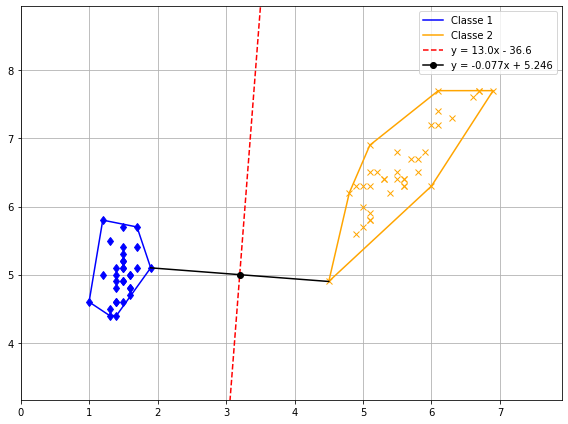

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        18
 Iris-virginica       1.00      1.00      1.00        12

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30


[Grafico 30%]:

Classe 1 30%:
[1.4, 5.1] [1.1, 4.3] [1.4, 5.0] [1.4, 5.2] [1.3, 4.7] [1.6, 5.0] [1.3, 5.0] [1.5, 5.0] [1.4, 5.5] [1.4, 4.8] [1.5, 5.4] [1.3, 4.4] [1.9, 4.8] [1.7, 5.4] [1.6, 5.1] [1.5, 4.9] [1.3, 5.4] [1.5, 5.1] 
Classe 2 30%:
[5.7, 6.9] [4.9, 6.1] [6.4, 7.9] [5.9, 7.1] [5.6, 6.7] [5.8, 7.2] [5.2, 6.7] [4.8, 6.0] [5.4, 6.9] [5.6, 6.1] [5.1, 5.8] [5.7, 6.7] 

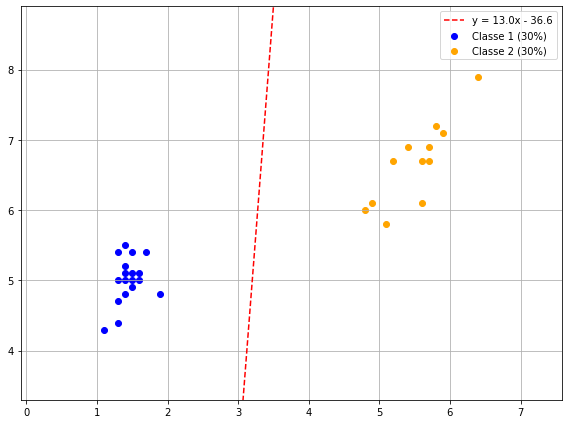

In [ ]:
#dset = []
#dset.append("iris.csv")

print("1. Analise do dataset: iris.csv")
analise("iris.csv")
print("\n")

##2 - TEXTURE DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=72

2. Analise do dataset: texture.csv

Atributos:  ['A1' ' A2' ' A3' ' A4' ' A5' ' A6' ' A7' ' A8' ' A9' ' A10' ' A11' ' A12'
 ' A13' ' A14' ' A15' ' A16' ' A17' ' A18' ' A19' ' A20' ' A21' ' A22'
 ' A23' ' A24' ' A25' ' A26' ' A27' ' A28' ' A29' ' A30' ' A31' ' A32'
 ' A33' ' A34' ' A35' ' A36' ' A37' ' A38' ' A39' ' A40']

Atributos utilizados como X e Y:   A16 ,  A38 


Envoltoria 1: 
[-619.0, -551.0] [-0.53, -534.0] [-0.37, -517.0] [-0.25, -377.0] [-0.24, -349.0] [-0.35, -0.47] [-0.46, -0.3] [-491.0, -0.28] [-597.0, -0.5] 
Envoltoria 2: 
[-0.63, -729.0] [-0.51, -614.0] [-0.43, -454.0] [-0.46, -329.0] [-0.54, -0.5] [-0.55, -0.46] [-529.0, -0.27] [-631.0, -0.39] [-702.0, -0.68] [-715.0, -584.0] [-701.0, -695.0] [-604.0, -704.0] 
As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.
Classes: 8, 14


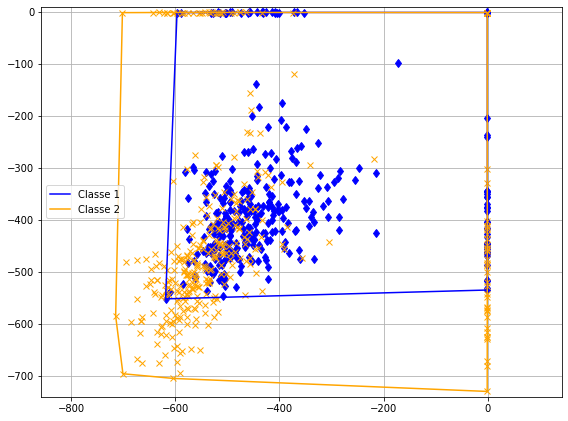

In [ ]:
print("2. Analise do dataset: texture.csv")
analise("texture.csv")
print("\n")

##3 - BANANA DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=182

3. Analise do dataset: banana.csv

Atributos:  ['at1' 'at2']

Atributos utilizados como X e Y:  at2 , at1 


Envoltoria 1: 
[-0.832, -3.09] [-0.16, -2.98] [0.096, -2.77] [0.96, -1.93] [2.47, -0.222] [2.52, 0.673] [2.19, 1.23] [-0.448, 2.44] [-1.15, 2.59] [-1.4, 2.25] [-1.71, 0.196] [-1.73, -0.558] [-1.65, -1.01] 
Envoltoria 2: 
[-1.02, -2.28] [-0.523, -2.17] [-0.347, -2.13] [0.106, -1.9] [1.94, -0.635] [2.19, -0.308] [2.18, -0.081] [2.04, 0.713] [1.64, 2.34] [1.47, 2.75] [1.3, 2.81] [-2.16, 1.63] [-2.39, 1.26] [-2.24, -1.91] [-1.88, -2.18] 
As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.
Classes: -1.0, 1.0


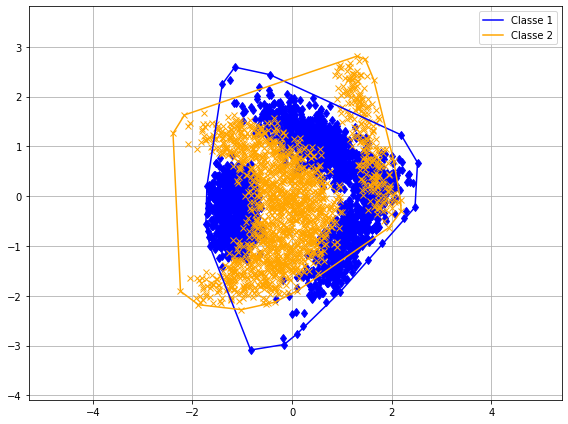

In [ ]:
print("3. Analise do dataset: banana.csv")
analise("banana.csv")
print("\n")

##4 - LIBRAS MOVEMENT DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=165

4. Analise do dataset: movement_libras.csv

Atributos:  ['1st_coordinate_abcissa' ' 1st_coordinate_ordinate'
 ' 2st_coordinate_abcissa' ' 2st_coordinate_ordinate'
 ' 3st_coordinate_abcissa' ' 3st_coordinate_ordinate'
 ' 4st_coordinate_abcissa' ' 4st_coordinate_ordinate'
 ' 5st_coordinate_abcissa' ' 5st_coordinate_ordinate'
 ' 6st_coordinate_abcissa' ' 6st_coordinate_ordinate'
 ' 7st_coordinate_abcissa' ' 7st_coordinate_ordinate'
 ' 8st_coordinate_abcissa' ' 8st_coordinate_ordinate'
 ' 9st_coordinate_abcissa' ' 9st_coordinate_ordinate'
 ' 10st_coordinate_abcissa' ' 10st_coordinate_ordinate'
 ' 11st_coordinate_abcissa' ' 11st_coordinate_ordinate'
 ' 12st_coordinate_abcissa' ' 12st_coordinate_ordinate'
 ' 13st_coordinate_abcissa' ' 13st_coordinate_ordinate'
 ' 14st_coordinate_abcissa' ' 14st_coordinate_ordinate'
 ' 15st_coordinate_abcissa' ' 15st_coordinate_ordinate'
 ' 16st_coordinate_abcissa' ' 16st_coordinate_ordinate'
 ' 17st_coordinate_abcissa' ' 17st_coordinate_ordinate'
 ' 18st_coo

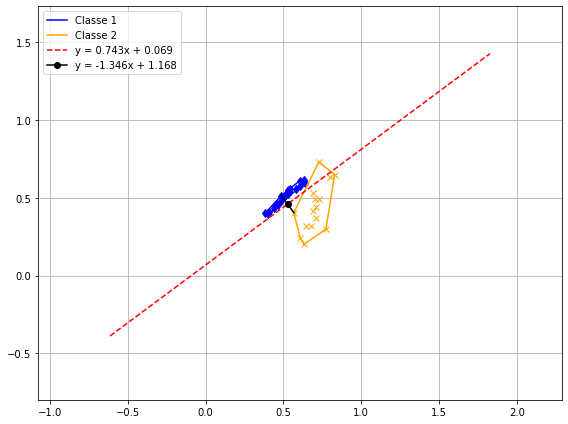

              precision    recall  f1-score   support

           2       0.71      1.00      0.83         5
           8       1.00      0.78      0.88         9

    accuracy                           0.86        14
   macro avg       0.86      0.89      0.85        14
weighted avg       0.90      0.86      0.86        14


[Grafico 30%]:

Classe 1 30%:
[0.42593000000000003, 0.42593000000000003] [0.76389, 0.65278] [0.55556, 0.52315] [0.63657, 0.63657] [0.5162, 0.52778] [0.8402799999999999, 0.73611] [0.47222, 0.42361000000000004] 
Classe 2 30%:
[0.75, 0.44443999999999995] [0.7338, 0.45602] [0.70602, 0.39815] [0.72917, 0.56019] [0.71991, 0.43518999999999997] [0.66435, 0.3125] [0.67824, 0.2037] 

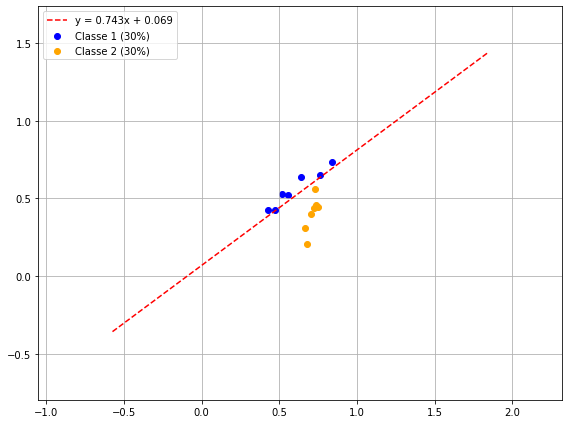

In [ ]:
print("4. Analise do dataset: movement_libras.csv")
analise("movement_libras.csv")
print("\n")

##5 - VEHICLES SILHOUETTES DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=68

5. Analise do dataset: vehicle.csv

Atributos:  ['Compactness' ' Circularity' ' Distance_circularity' ' Radius_ratio'
 ' Praxis_aspect_ratio' ' Max_length_aspect_ratio' ' Scatter_ratio'
 ' Elongatedness' ' Praxis_rectangular' ' Length_rectangular'
 ' Major_variance' ' Minor_variance' ' Gyration_radius' ' Major_skewness'
 ' Minor_skewness' ' Minor_kurtosis' ' Major_kurtosis' ' Hollows_ratio']

Atributos utilizados como X e Y:   Distance_circularity ,  Hollows_ratio 


Envoltoria 1: 
[66, 181] [106, 181] [109, 183] [95, 194] [81, 204] [79, 205] [62, 209] [59, 182] 
Envoltoria 2: 
[54, 183] [55, 183] [77, 187] [100, 194] [106, 196] [109, 199] [112, 206] [109, 208] [78, 211] [69, 209] [57, 195] [53, 190] [50, 185] 
As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.
Classes:  bus ,  saab


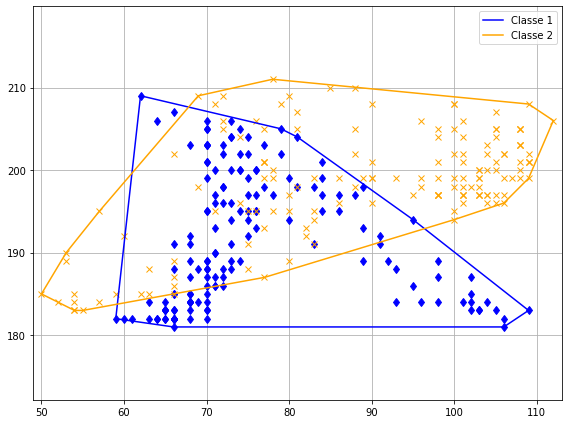

In [ ]:
print("5. Analise do dataset: vehicle.csv")
analise("vehicle.csv")
print("\n")

##6 - RED WINE QUALITY DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=210

6. Analise do dataset: winequality-red.csv

Atributos:  ['FixedAcidity' ' VolatileAcidity' ' CitricAcid' ' ResidualSugar'
 ' Chlorides' ' FreeSulfurDioxide' ' TotalSulfurDioxide' ' Density' ' PH'
 ' Sulphates' ' Alcohol']

Atributos utilizados como X e Y:   ResidualSugar ,  Sulphates 


Envoltoria 1: 
[2.1, 0.4] [4.25, 0.54] [2.1, 0.63] [1.8, 0.63] 
Envoltoria 2: 
[1.8, 0.33] [6.3, 0.56] [3.4, 2.0] [1.5, 1.12] [1.4, 0.48] [1.6, 0.37] 
As envoltórias convexas se sobrepõem. Dados das classes nao sao linearmente separaveis
Classes: 3, 4


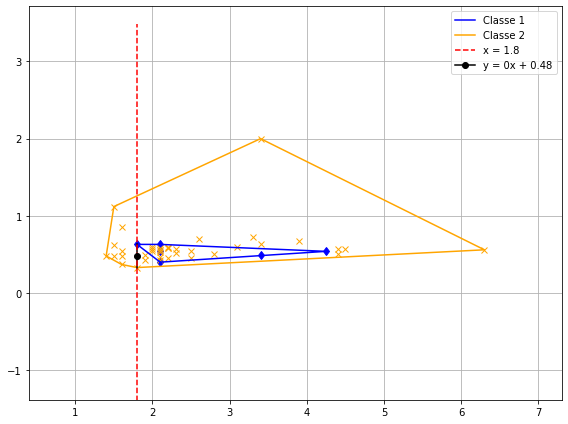

In [ ]:
print("6. Analise do dataset: winequality-red.csv")
analise("winequality-red.csv")
print("\n")

##7 - PAGE BLOCKS CLASSIFICATION DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=104

7. Analise do dataset: page-blocks.csv

Atributos:  ['Height' ' Lenght' ' Area' ' Eccen' ' P_black' ' P_and' ' Mean_tr'
 ' Blackpix' ' Blackand' ' Wb_trans']

Atributos utilizados como X e Y:   Eccen ,  Blackpix 


Envoltoria 1: 
[1103.0, 401] [1143.0, 414] [1795.0, 4804] [2843.0, 28093] [863.0, 19430] [804.0, 18591] [754.0, 10947] [769.0, 1475] [1069.0, 416] 
Envoltoria 2: 
[0.4, 7] [143.0, 7] [286.0, 9] [14.0, 1689] [0.007, 135] [0.009, 117] [0.04, 25] [0.05, 20] [0.1, 9] 
Dados das classes sao linearmente separaveis
Classes: 3, 4


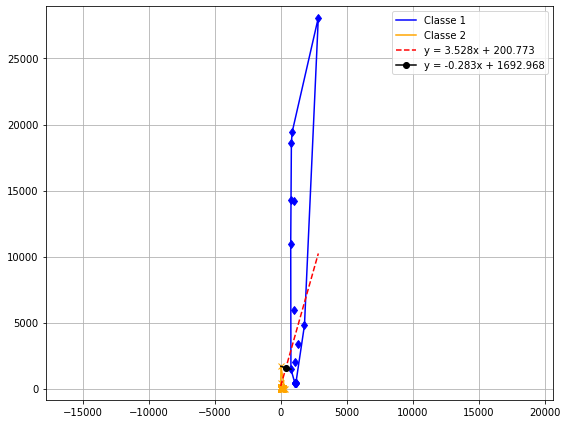

              precision    recall  f1-score   support

           3       0.11      0.30      0.16        10
           4       0.00      0.00      0.00        24

    accuracy                           0.09        34
   macro avg       0.06      0.15      0.08        34
weighted avg       0.03      0.09      0.05        34


[Grafico 30%]:

Classe 1 30%:
[1103.0, 442] [111.0, 9] [21.0, 47] [37.0, 27] [59.0, 17] [31.0, 141] [45.0, 130] [77.0, 13] [52.0, 59] [118.0, 24] [24.0, 42] [111.0, 9] [71.0, 14] [125.0, 7] [148.0, 41] [125.0, 8] [1141.0, 1882] [143.0, 7] [143.0, 7] [45.0, 22] [29.0, 34] [25.0, 25] [71.0, 14] [115.0, 492] [1254.0, 1681] [111.0, 9] [13.0, 76] 
Classe 2 30%:
[2522.0, 33017] [2711.0, 17721] [1118.0, 4366] [4144.0, 26693] [2707.0, 27820] [988.0, 13725] [733.0, 23025] 

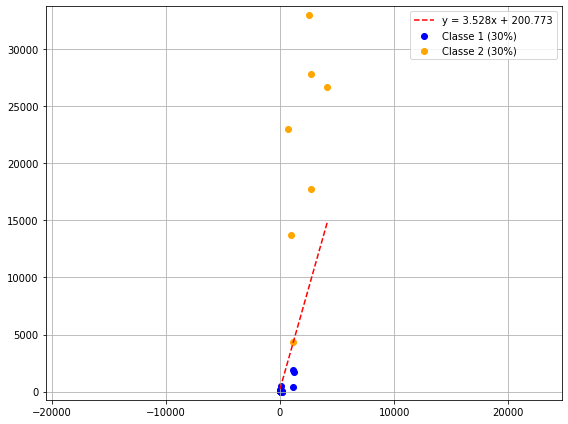

In [ ]:
print("7. Analise do dataset: page-blocks.csv")
analise("page-blocks.csv")
print("\n")

##8 - SPECTF HEART DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=185

8. Analise do dataset: spectfheart.csv

Atributos:  ['F1R' ' F1S' ' F2R' ' F2S' ' F3R' ' F3S' ' F4R' ' F4S' ' F5R' ' F5S'
 ' F6R' ' F6S' ' F7R' ' F7S' ' F8R' ' F8S' ' F9R' ' F9S' ' F10R' ' F10S'
 ' F11R' ' F11S' ' F12R' ' F12S' ' F13R' ' F13S' ' F14R' ' F14S' ' F15R'
 ' F15S' ' F16R' ' F16S' ' F17R' ' F17S' ' F18R' ' F18S' ' F19R' ' F19S'
 ' F20R' ' F20S' ' F21R' ' F21S' ' F22R' ' F22S']

Atributos utilizados como X e Y:   F18R ,  F3R 


Envoltoria 1: 
[64, 47] [68, 49] [72, 62] [72, 72] [71, 76] [61, 77] [50, 76] 
Envoltoria 2: 
[43, 21] [66, 24] [75, 63] [73, 77] [71, 80] [66, 82] [49, 80] [31, 75] [18, 68] 
As envoltórias convexas se sobrepõem. Dados das classes nao sao linearmente separaveis
Classes: 0, 1


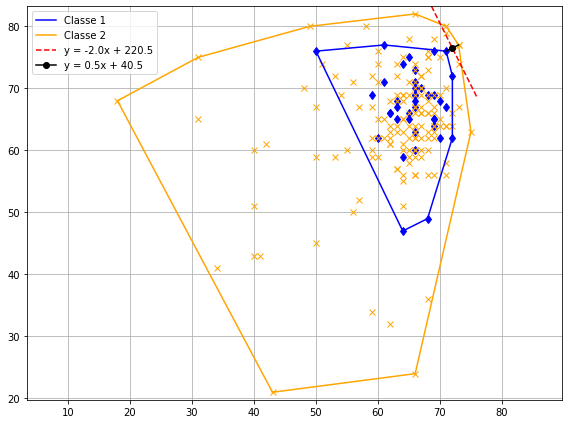

In [ ]:
print("8. Analise do dataset: spectfheart.csv")
analise("spectfheart.csv")
print("\n")

##9 - IMAGE SEGMENTTATION DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=107

9. Analise do dataset: segment.csv

Atributos:  ['Region-centroid-col' ' Region-centroid-row' ' Region-pixel-count'
 ' Short-line-density-5' ' Short-line-density-2' ' Vedge-mean' ' Vegde-sd'
 ' Hedge-mean' ' Hedge-sd' ' Intensity-mean' ' Rawred-mean'
 ' Rawblue-mean' ' Rawgreen-mean' ' Exred-mean' ' Exblue-mean'
 ' Exgreen-mean' ' Value-mean' ' Saturatoin-mean' ' Hue-mean']

Atributos utilizados como X e Y:   Rawblue-mean ,  Exblue-mean 


Envoltoria 1: 
[4.0, 0.222] [5.444, 0.667] [5.667, 0.778] [16.889, 6.556] [20.0, 8.222] [30.0, 18.444] [37.667, 27.111] [38.222, 29.444] [36.0, 28.667] [34.333, 27.778] [11.889, 13.111] [7.444, 8.556] [6.667, 7.556] [5.556, 5.222] 
Envoltoria 2: 
[148.889, 21.222] [150.889, 22.333] [150.111, 28.0] [145.333, 45.556] [140.778, 53.444] [128.444, 73.0] [115.889, 82.0] [112.111, 77.444] [122.444, 50.333] 
Dados das classes sao linearmente separaveis
Classes: 1, 2


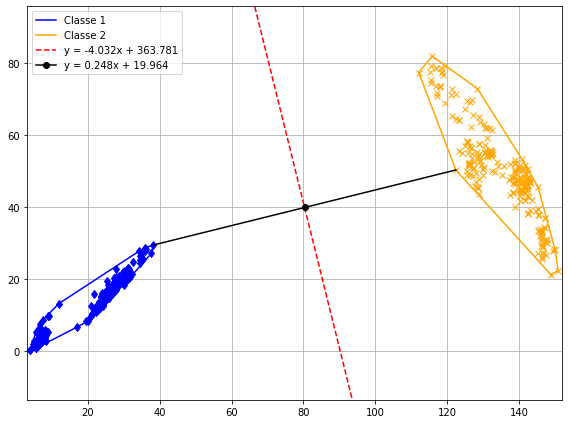

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       101
           2       1.00      1.00      1.00        97

    accuracy                           1.00       198
   macro avg       1.00      1.00      1.00       198
weighted avg       1.00      1.00      1.00       198


[Grafico 30%]:

Classe 1 30%:
[6.666666499999999, 3.5555556000000004] [7.333333500000001, 3.0] [22.11111, 12.0] [35.88889, 26.222221] [26.333334000000004, 15.555554999999998] [29.777779, 20.11111] [6.666666499999999, 2.6666667] [25.11111, 18.666666] [31.111109999999996, 25.555555] [27.222221, 18.0] [28.0, 18.444445] [25.444445, 15.555554999999998] [6.777777700000001, 5.0] [19.88889, 8.888889] [34.0, 23.88889] [27.555555, 17.555555] [7.333333500000001, 3.8888887999999997] [19.88889, 8.333333] [25.222220999999998, 19.444445] [27.444445, 17.666666] [20.666667999999998, 10.444445] [4.888889, 0.6666667] [6.666666499999999, 2.3333333] [7.888889, 4.3333335] [35.22222, 25

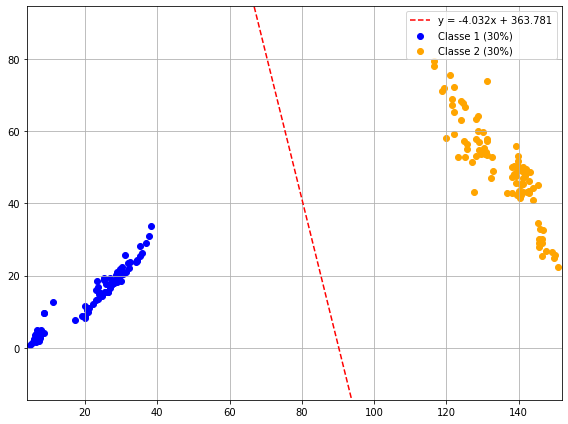

In [ ]:
print("9. Analise do dataset: segment.csv")
analise("segment.csv")
print("\n")

##10 - RINGNORM DATA SET

Disponível em: https://sci2s.ugr.es/keel/dataset.php?cod=106

10. Analise do dataset: ring.csv

Atributos:  ['A1' ' A2' ' A3' ' A4' ' A5' ' A6' ' A7' ' A8' ' A9' ' A10' ' A11' ' A12'
 ' A13' ' A14' ' A15' ' A16' ' A17' ' A18' ' A19' ' A20']

Atributos utilizados como X e Y:   A16 ,  A11 


Envoltoria 1: 
[-1156.0, -7803.0] [-356.0, -7621.0] [4574.0, -5822.0] [6403.0, -2168.0] [6905.0, 2642.0] [3768.0, 5652.0] [-79.0, 7208.0] [-3751.0, 5575.0] [-4557.0, 4964.0] [-7121.0, 577.0] [-6779.0, -1216.0] [-5908.0, -5163.0] 
Envoltoria 2: 
[-823.0, -3436.0] [2127.0, -2429.0] [2757.0, -2194.0] [3729.0, -286.0] [3713.0, 1192.0] [3047.0, 2442.0] [2569.0, 3261.0] [-53.0, 3688.0] [-1208.0, 3015.0] [-2619.0, 2038.0] [-3709.0, -974.0] [-2361.0, -2485.0] 
As envoltórias convexas se sobrepõem. Dados das classes nao sao linearmente separaveis
Classes: 0, 1


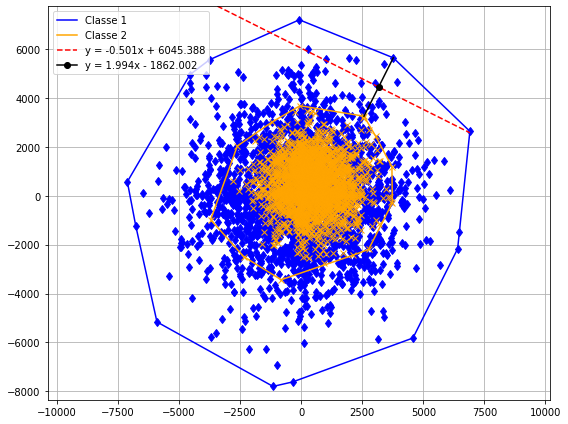

In [ ]:
print("10. Analise do dataset: ring.csv")
analise("ring.csv")
print("\n")

In [ ]:
#dir = 'csv/'
#dset = []
#for file in os.listdir(dir):
#    if file.endswith(".csv"):
#      dset.append(file)

#for i in range(len(dset)):
#  print("{}. Analise do dataset: {}".format(i+1, dset[i]))
#  analise(dset[i])
#  print("\n")

## Considerações finais

De maneira geral, este trabalho foi extremamente relevante para aprofundar nossa compreensão sobre o funcionamento do algoritmo Varredura de Graham, permitindo-nos estabelecer uma conexão mais próxima e aplicada aos conceitos abordados em sala de aula.

Durante o desenvolvimento deste projeto, pudemos consolidar muitos dos conceitos gerais sobre algoritmos aprendidos na sala de aula, resultando em uma experiência mais enriquecedora e uma compreensão aprofundada da matéria.




